# EasyOCR - Evaluation - 02 / 03- Preprocessing mit CLAHE

In diesem notebook wird ein zweiter Ansatz des Preprocessing ausprobiert mit CLAHE (Contrast Limited Adaptive Histogram Equalization)

es werden andere parameter ausprobiert:    
alphas = [0.8, 1.5, 2.3, 3.5]         
    betas = [-50, 0, 60, 120] 

In [1]:

import cv2
import numpy as np
from easyocr import Reader

# 1. CLAHE
def apply_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray)

# 2. Aggressive Varianten
def generate_variants(image):
    variants = []
    alphas = [0.8, 1.5, 2.3, 3.5]       # Kontrast
    betas = [-50, 0, 60, 120]           # Helligkeit

    for alpha in alphas:
        for beta in betas:
            adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
            variants.append((adjusted, f"alpha={alpha}, beta={beta}"))
    return variants

# 3. OCR + Confidence-Filter
def run_easyocr(image, reader, conf_thresh=0.4):
    results = reader.readtext(image)
    return [r for r in results if r[2] >= conf_thresh]

# 4. Merge-Ergebnisse: nach BoundingBox-Mittelpunkt clustern (einfach, aber effektiv)
def merge_results(all_results, iou_thresh=0.3):
    merged = []
    seen = []

    for res in all_results:
        (tl, tr, br, bl), text, conf = res
        center = ((tl[0] + br[0]) / 2, (tl[1] + br[1]) / 2)

        if any(np.linalg.norm(np.array(center) - np.array(seen_c)) < 30 for seen_c in seen):
            continue
        seen.append(center)
        merged.append((text, conf))
    
    return merged

# 4.1 nur zeilen mergen mit hoher confidence
def merge_results2(all_results, distance_thresh=30):
    merged = []
    for res in all_results:
        (tl, tr, br, bl), text, conf = res
        center = ((tl[0] + br[0]) / 2, (tl[1] + br[1]) / 2)

        # Prüfen, ob ein vorhandenes Ergebnis in der Nähe ist
        updated = False
        for i, (existing_text, existing_conf, existing_box) in enumerate(merged):
            existing_center = ((existing_box[0][0] + existing_box[2][0]) / 2,
                               (existing_box[0][1] + existing_box[2][1]) / 2)
            dist = np.linalg.norm(np.array(center) - np.array(existing_center))

            if dist < distance_thresh:
                # Wenn das neue Ergebnis besser ist → ersetzen
                if conf > existing_conf:
                    merged[i] = (text, conf, (tl, tr, br, bl))
                updated = True
                break

        if not updated:
            merged.append((text, conf, (tl, tr, br, bl)))

    return merged

# 4.2 merge mit treshold um schlechtere Ergebnisse nicht auszugeben
def merge_results_tresh(all_results, distance_thresh=30, conf_thresh=0.5):
    merged = []
    for res in all_results:
        (tl, tr, br, bl), text, conf = res

        # ➤ Confidence-Filter
        if conf < conf_thresh:
            continue

        center = ((tl[0] + br[0]) / 2, (tl[1] + br[1]) / 2)

        updated = False
        for i, (existing_text, existing_conf, existing_box) in enumerate(merged):
            existing_center = ((existing_box[0][0] + existing_box[2][0]) / 2,
                               (existing_box[0][1] + existing_box[2][1]) / 2)
            dist = np.linalg.norm(np.array(center) - np.array(existing_center))

            if dist < distance_thresh:
                if conf > existing_conf:
                    merged[i] = (text, conf, (tl, tr, br, bl))
                updated = True
                break

        if not updated:
            merged.append((text, conf, (tl, tr, br, bl)))

    return merged

##########################################################
# 5. Main
def process_image(image_path):
    reader = Reader(['de', 'en'])
    image = cv2.imread(image_path)
    
    clahe_img = apply_clahe(image)
    variants = generate_variants(clahe_img)
    
    all_results = []
    for img, desc in variants:
        results = run_easyocr(img, reader)
        print(f"[{desc}] erkannte Texte: {len(results)}")
        all_results.extend(results)
    
    merged_texts = merge_results(all_results)
    print(f"\n🎯 Gesamterkannte (gefilterte + gemergte) Texte: {len(merged_texts)}\n")
    for text, conf in merged_texts:
        print(f"{conf:.2f} -> {text}")

# 5.1 mit merge2 kombiniert
def process_image2(image_path):
    reader = Reader(['de', 'en'])
    image = cv2.imread(image_path)
    
    clahe_img = apply_clahe(image)
    variants = generate_variants(clahe_img)
    
    all_results = []
    for img, desc in variants:
        results = run_easyocr(img, reader)
        print(f"[{desc}] erkannte Texte: {len(results)}")
        all_results.extend(results)
    
    merged_texts = merge_results2(all_results)
    print(f"\n🎯 Gesamterkannte (gefilterte + gemergte) Texte: {len(merged_texts)}\n")
    for text, conf, _ in merged_texts: # Unterstrich für dritten parameter box, der soll nicht ausgegeben werden, wird ignoriert
        print(f"{conf:.2f} -> {text}")


# 5.2 mit merge mit treshold kombiniert
def process_image_tresh(image_path):
    reader = Reader(['de', 'en'])
    image = cv2.imread(image_path)
    
    clahe_img = apply_clahe(image)
    variants = generate_variants(clahe_img)
    
    all_results = []
    for img, desc in variants:
        results = run_easyocr(img, reader)
        print(f"[{desc}] erkannte Texte: {len(results)}")
        all_results.extend(results)
    
    merged_texts = merge_results_tresh(all_results)
    print(f"\n🎯 Gesamterkannte (gefilterte + gemergte) Texte: {len(merged_texts)}\n")
    for text, conf, _ in merged_texts: # Unterstrich für dritten parameter box, der soll nicht ausgegeben werden, wird ignoriert
        print(f"{conf:.2f} -> {text}")





In [2]:

process_image2("../../data/images/insta_images/0001.jpg")

[alpha=0.8, beta=-50] erkannte Texte: 6
[alpha=0.8, beta=0] erkannte Texte: 6
[alpha=0.8, beta=60] erkannte Texte: 6
[alpha=0.8, beta=120] erkannte Texte: 7
[alpha=1.5, beta=-50] erkannte Texte: 7
[alpha=1.5, beta=0] erkannte Texte: 6
[alpha=1.5, beta=60] erkannte Texte: 5
[alpha=1.5, beta=120] erkannte Texte: 5
[alpha=2.3, beta=-50] erkannte Texte: 6
[alpha=2.3, beta=0] erkannte Texte: 5
[alpha=2.3, beta=60] erkannte Texte: 3
[alpha=2.3, beta=120] erkannte Texte: 3
[alpha=3.5, beta=-50] erkannte Texte: 6
[alpha=3.5, beta=0] erkannte Texte: 4
[alpha=3.5, beta=60] erkannte Texte: 3
[alpha=3.5, beta=120] erkannte Texte: 3

🎯 Gesamterkannte (gefilterte + gemergte) Texte: 14

1.00 -> SPRACHCAFE
0.96 -> WEIHNACHTSFEIER
0.99 -> DIENSTAG 21.12.
0.90 -> OLOF-PALME ZENTRUM
0.99 -> 19 UHR
0.71 -> WIR FREUEN UnS AUF EUCH!
1.00 -> SP
0.99 -> CHCAFE
1.00 -> WE
0.59 -> ~HTSFFTER
0.92 -> 4
0.65 -> CHCA
0.44 -> HCA
0.61 -> TSF


In [2]:
# Beispiel-Aufruf
process_image("../../data/images/insta_images/0001.jpg")

[alpha=0.8, beta=-80] erkannte Texte: 6
[alpha=0.8, beta=0] erkannte Texte: 6
[alpha=0.8, beta=50] erkannte Texte: 6
[alpha=0.8, beta=100] erkannte Texte: 8
[alpha=1.2, beta=-80] erkannte Texte: 6
[alpha=1.2, beta=0] erkannte Texte: 5
[alpha=1.2, beta=50] erkannte Texte: 7
[alpha=1.2, beta=100] erkannte Texte: 3
[alpha=1.8, beta=-80] erkannte Texte: 7
[alpha=1.8, beta=0] erkannte Texte: 6
[alpha=1.8, beta=50] erkannte Texte: 5
[alpha=1.8, beta=100] erkannte Texte: 3
[alpha=2.5, beta=-80] erkannte Texte: 7
[alpha=2.5, beta=0] erkannte Texte: 4
[alpha=2.5, beta=50] erkannte Texte: 4
[alpha=2.5, beta=100] erkannte Texte: 2

🎯 Gesamterkannte (gefilterte + gemergte) Texte: 12

0.94 -> SPRACHCAFE
0.75 -> WEIHNACHTSFEIER
0.98 -> DIENSTAG 21.12
0.65 -> OLOF-PALME ZENTRUM
1.00 -> 19 UHR
0.65 -> WIR FREUEN UNS AUF EUCH!
1.00 -> SP
0.99 -> CHCAFE
0.79 -> WEIF
0.76 -> GHTSFEIER
0.67 -> CHCA
0.50 -> HTSFFFR


In [3]:
process_image2("../../data/images/insta_images/0239.jpg")

[alpha=0.8, beta=-50] erkannte Texte: 8
[alpha=0.8, beta=0] erkannte Texte: 9
[alpha=0.8, beta=60] erkannte Texte: 8
[alpha=0.8, beta=120] erkannte Texte: 8
[alpha=1.5, beta=-50] erkannte Texte: 11
[alpha=1.5, beta=0] erkannte Texte: 7
[alpha=1.5, beta=60] erkannte Texte: 7
[alpha=1.5, beta=120] erkannte Texte: 6
[alpha=2.3, beta=-50] erkannte Texte: 9
[alpha=2.3, beta=0] erkannte Texte: 6
[alpha=2.3, beta=60] erkannte Texte: 9
[alpha=2.3, beta=120] erkannte Texte: 2
[alpha=3.5, beta=-50] erkannte Texte: 8
[alpha=3.5, beta=0] erkannte Texte: 7
[alpha=3.5, beta=60] erkannte Texte: 2
[alpha=3.5, beta=120] erkannte Texte: 6

🎯 Gesamterkannte (gefilterte + gemergte) Texte: 20

1.00 -> 8€
1.00 -> Abend
0.97 -> Roter
1.00 -> Salon
0.66 -> Eintritt:
0.76 -> Wannz
0.73 -> CoLole
0.91 -> arbeitskaempfe@volksbuehne-berlin-de
0.94 -> PUN
0.49 -> 94
0.99 -> 4
0.65 -> Wer:
0.79 -> ZLu#2
0.95 -> 4
0.98 -> der
0.86 -> in
0.58 -> MOLKSBUANE
0.44 -> 492
0.49 -> 44
0.45 -> Derlin de


In [4]:
# Beispiel-Aufruf
process_image("../../data/images/insta_images/0239.jpg")

[alpha=0.8, beta=-50] erkannte Texte: 8
[alpha=0.8, beta=0] erkannte Texte: 9
[alpha=0.8, beta=60] erkannte Texte: 8
[alpha=0.8, beta=120] erkannte Texte: 8
[alpha=1.5, beta=-50] erkannte Texte: 11
[alpha=1.5, beta=0] erkannte Texte: 7
[alpha=1.5, beta=60] erkannte Texte: 7
[alpha=1.5, beta=120] erkannte Texte: 6
[alpha=2.3, beta=-50] erkannte Texte: 9
[alpha=2.3, beta=0] erkannte Texte: 6
[alpha=2.3, beta=60] erkannte Texte: 9
[alpha=2.3, beta=120] erkannte Texte: 2
[alpha=3.5, beta=-50] erkannte Texte: 8
[alpha=3.5, beta=0] erkannte Texte: 7
[alpha=3.5, beta=60] erkannte Texte: 2
[alpha=3.5, beta=120] erkannte Texte: 6

🎯 Gesamterkannte (gefilterte + gemergte) Texte: 20

1.00 -> 8€
1.00 -> Abend
0.93 -> Roter
1.00 -> Salon
0.66 -> Eintritt:
0.64 -> Wannz
0.73 -> CoLole
0.72 -> arbeitskaempfe@volksbuehne-berlin-de
0.66 -> PUNA
0.49 -> 94
0.92 -> 4
0.56 -> Wer:
0.79 -> ZLu#2
0.95 -> 4
0.47 -> der
0.86 -> in
0.51 -> VOLKSBUANE
0.44 -> 492
0.49 -> 44
0.45 -> Derlin de


In [95]:
process_image_tresh("../../data/images/insta_images/0180.jpg")

[alpha=0.8, beta=-80] erkannte Texte: 10
[alpha=0.8, beta=0] erkannte Texte: 11
[alpha=0.8, beta=50] erkannte Texte: 11
[alpha=0.8, beta=100] erkannte Texte: 3
[alpha=1.2, beta=-80] erkannte Texte: 12
[alpha=1.2, beta=0] erkannte Texte: 4
[alpha=1.2, beta=50] erkannte Texte: 3
[alpha=1.2, beta=100] erkannte Texte: 0
[alpha=1.8, beta=-80] erkannte Texte: 3
[alpha=1.8, beta=0] erkannte Texte: 1
[alpha=1.8, beta=50] erkannte Texte: 0
[alpha=1.8, beta=100] erkannte Texte: 0
[alpha=2.5, beta=-80] erkannte Texte: 0
[alpha=2.5, beta=0] erkannte Texte: 0
[alpha=2.5, beta=50] erkannte Texte: 0
[alpha=2.5, beta=100] erkannte Texte: 0

🎯 Gesamterkannte (gefilterte + gemergte) Texte: 20

0.99 -> IS PALESTINE
0.99 -> AFEMINIST
0.97 -> ISSUE?I
0.93 -> ZURVERSCHRANKUNG
1.00 -> VON
1.00 -> (QUEER-)FEMINISMUS
0.87 -> UND ANTISEMITISMUS
0.99 -> & Diskussion mit
0.95 -> Do 19.12.
0.83 -> 19-00 Uhr
0.83 -> Vortrag & Diskussion mit
0.98 -> Cordula Trunk
0.60 -> 4
1.00 -> FEMINIST
0.53 -> ;
1.00 -> Trunk
0.

In [96]:
import easyocr
from easyocr import Reader
reader = easyocr.Reader(['de', 'en'])  
result = reader.readtext('../../data/images/insta_images/0180.jpg', detail=0) # bei 0 wird boundingbox wird nicht angezeigt
print(result)

['IS PALESTINE', '4', 'FEMINIST', 'ISSUE?!', 'ZUR VERSCHRÄNKUNG', 'VON', '(QUEER-)FEMINISMUS', 'UND ANTISEMITISMUS', 'coaqfPiak', '& Diskussion mit', ';', 'Trunk', '|', 'Do 19.12.', ':', '19:00 Uhr', 'Ä']


---
### Anwendung auf gesamtem Datensatz

In [9]:
import os
import cv2
import numpy as np
import pandas as pd
from easyocr import Reader
import sys # ermöglicht Zugriff auf übergeordnetes Verzeichnis
sys.path.append(os.path.abspath("../../utils"))
from funktionen import cer_for_matching, match_gt_to_ocr, calculate_wer,calculate_cer, CER_THRESHOLD



# 1. CLAHE
def apply_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray)

# 2. Varianten
def generate_variants(image):
    variants = []
    alphas = [0.8, 1.5, 2.3, 3.5]       # Kontrast
    betas = [-50, 0, 60, 120] 
    for alpha in alphas:
        for beta in betas:
            adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
            variants.append((adjusted, f"alpha={alpha}, beta={beta}"))
    return variants

# 3. OCR mit Filter
def run_easyocr(image, reader, conf_thresh=0.4):
    results = reader.readtext(image)
    return [r for r in results if r[2] >= conf_thresh]

# 4. Merge nach Bounding-Box-Mittelpunkt
def merge_results(all_results, distance_thresh=30):
    merged = []
    for res in all_results:
        (tl, tr, br, bl), text, conf = res
        center = ((tl[0] + br[0]) / 2, (tl[1] + br[1]) / 2)

        # Prüfen, ob ein vorhandenes Ergebnis in der Nähe ist
        updated = False
        for i, (existing_text, existing_conf, existing_box) in enumerate(merged):
            existing_center = ((existing_box[0][0] + existing_box[2][0]) / 2,
                               (existing_box[0][1] + existing_box[2][1]) / 2)
            dist = np.linalg.norm(np.array(center) - np.array(existing_center))

            if dist < distance_thresh:
                # Wenn das neue Ergebnis besser ist → ersetzen
                if conf > existing_conf:
                    merged[i] = (text, conf, (tl, tr, br, bl))
                updated = True
                break

        if not updated:
            merged.append((text, conf, (tl, tr, br, bl)))

    return merged

# Evaluation
def evaluate_ocr_with_metrics(gt_lines, ocr_lines):
    matches = match_gt_to_ocr(gt_lines, ocr_lines)
    total_gt = len(gt_lines)
    total_ocr = len(ocr_lines)
    total_matches = sum(1 for (_, ocr_idx) in matches if ocr_idx is not None)

    cer_list = []
    wer_list = []

    for gt_idx, ocr_idx in matches:
        gt = gt_lines[gt_idx]
        pred = ocr_lines[ocr_idx] if ocr_idx is not None else ""
        cer_list.append(calculate_cer(gt, pred))
        wer_list.append(calculate_wer(gt, pred))

    mean_cer = sum(cer_list) / total_gt if total_gt else None
    mean_wer = sum(wer_list) / total_gt if total_gt else None

    return {
        "gt_lines": total_gt,
        "ocr_lines": total_ocr,
        "matched_lines": total_matches,
        "mean_cer": mean_cer,
        "mean_wer": mean_wer
        
    }



# 5. Hauptfunktion für ein Bild
def process_image(image_path, reader):
    image = cv2.imread(image_path)
    clahe_img = apply_clahe(image)
    variants = generate_variants(clahe_img)

    all_results = []
    for img, desc in variants:
        results = run_easyocr(img, reader)
        all_results.extend(results)
    
    merged = merge_results(all_results)
    return [text for text, conf, box in merged]  # ← Nur Texte extrahieren



# 6. Batch-Verarbeitung + CSV Export
def process_folder_with_eval(image_folder, gt_dict, output_csv):
    reader = Reader(['de', 'en'])
    results = []

    for fname in os.listdir(image_folder):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(image_folder, fname)
        print(f"🔍 Verarbeite: {fname}")
        try:
            ocr_lines = process_image(img_path, reader)  # EasyOCR-Ausgabe
            gt_lines = gt_dict.get(fname, [])

            eval_result = evaluate_ocr_with_metrics(gt_lines, ocr_lines)
            eval_result.update({
                "file_name": fname,
                "ocr_easyocr_clahe": ocr_lines
            })

            results.append(eval_result)

        except Exception as e:
            print(f"⚠️ Fehler bei {fname}: {e}")

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"\n✅ Export abgeschlossen: {output_csv} (Dateien: {len(df)})")




In [10]:
import os
import json
JSON_PATH = "../../data/original_text.json"

with open(JSON_PATH, "r", encoding="utf-8") as f:
    all_data = json.load(f)

gt_dict = {e["file_name"]: e.get("lines", []) for e in all_data if "file_name" in e}

process_folder_with_eval("../../data/images/insta_images", gt_dict, "../../data/OCR/easyocr/ocr_evaluation_clahe3.csv")


🔍 Verarbeite: 0071.jpg
🔍 Verarbeite: 0059.jpg
🔍 Verarbeite: 0111.jpg
🔍 Verarbeite: 0139.jpg
🔍 Verarbeite: 0110.jpg
🔍 Verarbeite: 0104.jpg
🔍 Verarbeite: 0039.jpeg
🔍 Verarbeite: 0064.jpg
🔍 Verarbeite: 0066.jpg
🔍 Verarbeite: 0072.jpg
🔍 Verarbeite: 0099.jpg
🔍 Verarbeite: 0112.jpg
🔍 Verarbeite: 0106.jpg
🔍 Verarbeite: 0113.jpg
🔍 Verarbeite: 0131.jpeg
🔍 Verarbeite: 0127.jpeg
🔍 Verarbeite: 0098.jpg
🔍 Verarbeite: 0170.jpeg
🔍 Verarbeite: 0063.jpg
🔍 Verarbeite: 0117.jpg
🔍 Verarbeite: 0103.jpg
🔍 Verarbeite: 0116.jpg
🔍 Verarbeite: 0018.jpeg
🔍 Verarbeite: 0062.jpg
🔍 Verarbeite: 0074.jpg
🔍 Verarbeite: 0060.jpg
🔍 Verarbeite: 0128.jpg
🔍 Verarbeite: 0100.jpg
🔍 Verarbeite: 0114.jpg
🔍 Verarbeite: 0115.jpg
🔍 Verarbeite: 0101.jpg
🔍 Verarbeite: 0129.jpg
🔍 Verarbeite: 0147.jpeg
🔍 Verarbeite: 0061.jpg
🔍 Verarbeite: 0075.jpg
🔍 Verarbeite: 0049.jpg
🔍 Verarbeite: 0012.jpg
🔍 Verarbeite: 0006.jpg
🔍 Verarbeite: 0210.jpg
🔍 Verarbeite: 0204.jpg
🔍 Verarbeite: 0238.jpg
🔍 Verarbeite: 0166.jpg
🔍 Verarbeite: 0172.jpg
🔍 Ver

In [1]:
import pandas as pd

df = pd.read_csv("../../data/OCR/easyocr/ocr_evaluation_clahe3.csv")

df.head()

,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,file_name,ocr_easyocr_clahe
0,7,16,3,0.660652,0.857143,0071.jpg,"['Freedom Porade |?11', '0', 'Brandeaburger To..."
1,7,13,2,0.763975,0.750000,0059.jpg,"['8.', '19 UHR, KUFA MOABIT_', 'Gcfordert durc..."
2,13,35,11,0.241408,0.297436,0111.jpg,"['50 JAHRE', 'RI', 'RUMBLE IN THE JUNGLE', 'Po..."
3,8,13,6,0.252193,0.265625,0139.jpg,"['MEHR POLIZEI?', 'NICHTS ZU FEIERN', 'WIR BLE..."
4,5,8,4,0.329697,0.900000,0110.jpg,"['CLUBS', 'STADT', 'KLIMAKRISE', 'MARKGRAFENDA..."


### Evaluation - Berechnung CER und WER - zeilenbasiert

In [2]:
df["recognition_rate"] = df["matched_lines"] / df["gt_lines"]

In [3]:
# Durchschnitt berechnen
mean_cer = df["mean_cer"].mean()
mean_wer = df["mean_wer"].mean()
mean_ER = df["recognition_rate"].mean()

# Ausgabe
print(f"Durchschnittswerte ganzer Datensatz:")
print(f"Erkennungsrate: {mean_ER:.3f}")
print(f"CER: {mean_cer:.3f}")
print(f"WER: {mean_wer:.3f}")

Durchschnittswerte ganzer Datensatz:
Erkennungsrate: 0.718
CER: 0.336
WER: 0.507


Werte ohne Preprocessing im Vergleich:  
Erkennungsrate: 0.722  
CER: 0.338  
WER: 0.525  

In [5]:
import pandas as pd
df_pics = pd.read_csv("../../data/image_data_with_groundtruth.csv")

In [6]:
# Nur relevante Spalten
df_reduced = df_pics[["file_name", "category"]]

merged_df = df.merge(df_reduced, on="file_name", how="left")

merged_df.head()

,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,file_name,ocr_easyocr_clahe,recognition_rate,category
0,7,16,3,0.660652,0.857143,0071.jpg,"['Freedom Porade |?11', '0', 'Brandeaburger To...",0.428571,fancy
1,7,13,2,0.763975,0.750000,0059.jpg,"['8.', '19 UHR, KUFA MOABIT_', 'Gcfordert durc...",0.285714,fancy
2,13,35,11,0.241408,0.297436,0111.jpg,"['50 JAHRE', 'RI', 'RUMBLE IN THE JUNGLE', 'Po...",0.846154,photo
3,8,13,6,0.252193,0.265625,0139.jpg,"['MEHR POLIZEI?', 'NICHTS ZU FEIERN', 'WIR BLE...",0.750000,simple
4,5,8,4,0.329697,0.900000,0110.jpg,"['CLUBS', 'STADT', 'KLIMAKRISE', 'MARKGRAFENDA...",0.800000,photo


In [7]:
CER_by_category = merged_df.groupby("category")["mean_cer"].mean() * 100
CER_by_category = CER_by_category.round(2)
CER_by_category = CER_by_category.sort_values(ascending=True)

print(CER_by_category)

category
simple    22.35
skewed    29.52
noisy     33.22
photo     42.03
fancy     46.55
Name: mean_cer, dtype: float64


CER ohne Preprocessing:  
category  
simple    22.30  
skewed    31.64  
noisy     33.40  
photo     41.88  
fancy     45.91  

In [8]:
WER_by_category = merged_df.groupby("category")["mean_cer"].mean() * 100
WER_by_category = WER_by_category.round(2)
WER_by_category = WER_by_category.sort_values(ascending=True)

print(WER_by_category)

category
simple    22.35
skewed    29.52
noisy     33.22
photo     42.03
fancy     46.55
Name: mean_cer, dtype: float64


WER ohne Preprocessing:  
simple    39.13  
skewed    51.64   
noisy     55.83  
fancy     62.73  
photo     65.32  

In [12]:
Erkennungsrate_by_category = merged_df.groupby("category")["recognition_rate"].mean() * 100
Erkennungsrate_by_category = Erkennungsrate_by_category.round(2)
Erkennungsrate_by_category = Erkennungsrate_by_category.sort_values(ascending=False)

print(Erkennungsrate_by_category)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
category
simple    81.97
skewed    76.86
noisy     71.74
photo     63.50
fancy     59.90
Name: recognition_rate, dtype: float64


Werte ohne Preprocessing:    
simple    82.53  
skewed    74.39  
noisy     72.47  
photo     64.97   
fancy     61.32  

---

### Evaluation - Berechnung CER und WER - erkannte Zeilen

In [61]:
import os
import cv2
import numpy as np
import pandas as pd
from easyocr import Reader
import sys # ermöglicht Zugriff auf übergeordnetes Verzeichnis
sys.path.append(os.path.abspath("../../utils"))
from funktionen import cer_for_matching, match_gt_to_ocr, calculate_char_accuracy, calculate_word_accuracy, calculate_wer,calculate_cer, CER_THRESHOLD



# 1. CLAHE
def apply_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray)

# 2. Varianten
def generate_variants(image):
    variants = []
    alphas = [0.8, 1.2, 1.8, 2.5]
    betas = [-80, 0, 50, 100]
    for alpha in alphas:
        for beta in betas:
            adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
            variants.append((adjusted, f"alpha={alpha}, beta={beta}"))
    return variants

# 3. OCR mit Filter
def run_easyocr(image, reader, conf_thresh=0.4):
    results = reader.readtext(image)
    return [r for r in results if r[2] >= conf_thresh]

# 4. Merge nach Bounding-Box-Mittelpunkt
def merge_results(all_results, distance_thresh=30):
    merged = []
    for res in all_results:
        (tl, tr, br, bl), text, conf = res
        center = ((tl[0] + br[0]) / 2, (tl[1] + br[1]) / 2)

        # Prüfen, ob ein vorhandenes Ergebnis in der Nähe ist
        updated = False
        for i, (existing_text, existing_conf, existing_box) in enumerate(merged):
            existing_center = ((existing_box[0][0] + existing_box[2][0]) / 2,
                               (existing_box[0][1] + existing_box[2][1]) / 2)
            dist = np.linalg.norm(np.array(center) - np.array(existing_center))

            if dist < distance_thresh:
                # Wenn das neue Ergebnis besser ist → ersetzen
                if conf > existing_conf:
                    merged[i] = (text, conf, (tl, tr, br, bl))
                updated = True
                break

        if not updated:
            merged.append((text, conf, (tl, tr, br, bl)))

    return merged

# Evaluation nur gematchte zeilen
def evaluate_ocr_with_metrics_match(gt_lines, ocr_lines):
    matches = match_gt_to_ocr(gt_lines, ocr_lines)
    total_gt = len(gt_lines)
    total_ocr = len(ocr_lines)
    total_matches = sum(1 for (_, ocr_idx) in matches if ocr_idx is not None)

    matched_cer = []
    matched_wer = []

    for gt_idx, ocr_idx in matches:
        if ocr_idx is not None:
            gt = gt_lines[gt_idx]
            pred = ocr_lines[ocr_idx]
            matched_cer.append(calculate_cer(gt, pred))
            matched_wer.append(calculate_wer(gt, pred))

    mean_cer = sum(matched_cer) / len(matched_cer) if matched_cer else None
    mean_wer = sum(matched_wer) / len(matched_wer) if matched_wer else None

    return {
        "gt_lines": total_gt,
        "ocr_lines": total_ocr,
        "matched_lines": total_matches,
        "mean_cer": mean_cer,
        "mean_wer": mean_wer
    }




# 5. Hauptfunktion für ein Bild
def process_image(image_path, reader):
    image = cv2.imread(image_path)
    clahe_img = apply_clahe(image)
    variants = generate_variants(clahe_img)

    all_results = []
    for img, desc in variants:
        results = run_easyocr(img, reader)
        all_results.extend(results)
    
    merged = merge_results(all_results)
    return [text for text, conf, box in merged]  # ← Nur Texte extrahieren


# 6. Batch-Verarbeitung + CSV Export
def process_folder_with_eval_match(image_folder, gt_dict, output_csv):
    reader = Reader(['de', 'en'])
    results = []

    for fname in os.listdir(image_folder):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(image_folder, fname)
        print(f"🔍 Verarbeite: {fname}")
        try:
            ocr_lines = process_image(img_path, reader)  # EasyOCR-Ausgabe
            gt_lines = gt_dict.get(fname, [])

            eval_result = evaluate_ocr_with_metrics_match(gt_lines, ocr_lines)
            eval_result.update({
                "file_name": fname,
                "ocr_easyocr_clahe": ocr_lines
            })

            results.append(eval_result)

        except Exception as e:
            print(f"⚠️ Fehler bei {fname}: {e}")

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"\n✅ Export abgeschlossen: {output_csv} (Dateien: {len(df)})")

In [62]:
import os
import json
JSON_PATH = "../../data/original_text.json"

with open(JSON_PATH, "r", encoding="utf-8") as f:
    all_data = json.load(f)

gt_dict = {e["file_name"]: e.get("lines", []) for e in all_data if "file_name" in e}

process_folder_with_eval_match("../../data/images/insta_images", gt_dict, "../../data/OCR/ocr_evaluation_clahe_matched_lines.csv")

🔍 Verarbeite: 0071.jpg
🔍 Verarbeite: 0059.jpg
🔍 Verarbeite: 0111.jpg
🔍 Verarbeite: 0139.jpg
🔍 Verarbeite: 0110.jpg
🔍 Verarbeite: 0104.jpg
🔍 Verarbeite: 0039.jpeg
🔍 Verarbeite: 0064.jpg
🔍 Verarbeite: 0066.jpg
🔍 Verarbeite: 0072.jpg
🔍 Verarbeite: 0099.jpg
🔍 Verarbeite: 0112.jpg
🔍 Verarbeite: 0106.jpg
🔍 Verarbeite: 0113.jpg
🔍 Verarbeite: 0131.jpeg
🔍 Verarbeite: 0127.jpeg
🔍 Verarbeite: 0098.jpg
🔍 Verarbeite: 0170.jpeg
🔍 Verarbeite: 0063.jpg
🔍 Verarbeite: 0117.jpg
🔍 Verarbeite: 0103.jpg
🔍 Verarbeite: 0116.jpg
🔍 Verarbeite: 0018.jpeg
🔍 Verarbeite: 0062.jpg
🔍 Verarbeite: 0074.jpg
🔍 Verarbeite: 0060.jpg
🔍 Verarbeite: 0128.jpg
🔍 Verarbeite: 0100.jpg
🔍 Verarbeite: 0114.jpg
🔍 Verarbeite: 0115.jpg
🔍 Verarbeite: 0101.jpg
🔍 Verarbeite: 0129.jpg
🔍 Verarbeite: 0147.jpeg
🔍 Verarbeite: 0061.jpg
🔍 Verarbeite: 0075.jpg
🔍 Verarbeite: 0049.jpg
🔍 Verarbeite: 0012.jpg
🔍 Verarbeite: 0006.jpg
🔍 Verarbeite: 0210.jpg
🔍 Verarbeite: 0204.jpg
🔍 Verarbeite: 0238.jpg
🔍 Verarbeite: 0166.jpg
🔍 Verarbeite: 0172.jpg
🔍 Ver

In [63]:
import pandas as pd

df = pd.read_csv("../../data/OCR/ocr_evaluation_clahe_matched_lines.csv")

df.head()

,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,file_name,ocr_easyocr_clahe
0,7,17,4,0.248665,0.666667,0071.jpg,"['Grafir:', 'Siegessävle', 'Stare:', '2020', '..."
1,7,19,2,0.173913,0.125000,0059.jpg,"['n', '8.', 'Sozialraunorientierte', 'HEDY', '..."
2,13,33,11,0.090495,0.151515,0111.jpg,"['50 JAHRE', 'RUMBLE IN THE JUNGLE', 'Podium:'..."
3,8,14,6,0.002924,0.020833,0139.jpg,"['MEHR POLIZEI?', 'NICHTS ZU FEIERN', 'KUNDGEB..."
4,5,9,4,0.162121,0.875000,0110.jpg,"['CLUBS', 'STADT', 'KLIMAKRISE', 'A1gg WEGBASS..."


In [64]:
df["recognition_rate"] = df["matched_lines"] / df["gt_lines"]

In [65]:
# Durchschnitt berechnen
mean_cer = df["mean_cer"].mean()
mean_wer = df["mean_wer"].mean()
mean_ER = df["recognition_rate"].mean()

# Ausgabe
print(f"Durchschnittswerte ganzer Datensatz:")
print(f"Erkennungsrate: {mean_ER:.3f}")
print(f"CER: {mean_cer:.3f}")
print(f"WER: {mean_wer:.3f}")

Durchschnittswerte ganzer Datensatz:
Erkennungsrate: 0.731
CER: 0.089
WER: 0.352


Werte ohne Preprocessing:  
Erkennungsrate: 0.723  
CER: 0.097  
WER: 0.380  

---
### Evaluation - auf Entitäten prüfen

In [72]:
import json
import pandas as pd

JSON_PATH = "../../data/data_annotated.json"
CSV_PATH = "../../data/OCR/ocr_evaluation_clahe_matched_lines.csv"
OUTPUT_PATH = "../../data/OCR/cr_evaluation_clahe_entities.csv"

# JSON & CSV laden
with open(JSON_PATH, "r", encoding="utf-8") as f:
    gt_data = json.load(f)

ocr_df = pd.read_csv(CSV_PATH)

# NaN in 'ocr_text' durch leeren String ersetzen
ocr_df["ocr_easyocr_clahe"] = ocr_df["ocr_easyocr_clahe"].fillna("")

# Alle Labels, die wir tracken wollen
labels_to_track = ["EVENT", "TOPIC", "DATE", "TIME", "LOC"]

# Ergebnisliste
results = []

for gt_entry in gt_data:
    file_name = gt_entry["file_name"]
    gt_entities = gt_entry.get("entities", [])

    # OCR-Text zur Datei holen
    ocr_row = ocr_df[ocr_df["file_name"] == file_name]
    if ocr_row.empty:
        print(f"OCR-Text für {file_name} nicht gefunden – übersprungen.")
        continue
    ocr_text = ocr_row.iloc[0]["ocr_easyocr_clahe"]

    # Initiale Zähler
    result_row = {"file_name": file_name}
    for label in labels_to_track:
        result_row[f"Anzahl_{label}_gt"] = 0
        result_row[f"Anzahl_{label}_erkannt"] = 0

    erkannte_entitaeten = []
    nicht_erkannte_entitaeten = []

    for ent in gt_entities:
        label = ent["label"]
        text = ent["text"]

        if label not in labels_to_track:
            continue

        # Ground-Truth-Zähler erhöhen
        result_row[f"Anzahl_{label}_gt"] += 1

        # Prüfen, ob Text im OCR vorkommt
        if text in ocr_text:
            result_row[f"Anzahl_{label}_erkannt"] += 1
            erkannte_entitaeten.append(f"[{label}] {text}")
        else:
            nicht_erkannte_entitaeten.append(f"[{label}] {text}")

    # Listen speichern als Strings
    result_row["erkannte_entities"] = "; ".join(erkannte_entitaeten)
    result_row["nicht_erkannte_entities"] = "; ".join(nicht_erkannte_entitaeten)

    results.append(result_row)

# In DataFrame umwandeln und speichern
df_result = pd.DataFrame(results)
df_result.to_csv(OUTPUT_PATH, index=False, encoding="utf-8")

print(f"Auswertung gespeichert in: {OUTPUT_PATH}")

Auswertung gespeichert in: ../../data/OCR/cr_evaluation_clahe_entities.csv


In [73]:
df = pd.read_csv("../../data/OCR/cr_evaluation_clahe_entities.csv")
df.head(1)


,file_name,Anzahl_EVENT_gt,Anzahl_EVENT_erkannt,Anzahl_TOPIC_gt,Anzahl_TOPIC_erkannt,Anzahl_DATE_gt,Anzahl_DATE_erkannt,Anzahl_TIME_gt,Anzahl_TIME_erkannt,Anzahl_LOC_gt,Anzahl_LOC_erkannt,erkannte_entities,nicht_erkannte_entities
0,0001.jpg,1,1,0,0,2,1,1,1,2,1,[EVENT] WEIHNACHTSFEIER; [DATE] DIENSTAG; [TIM...,[DATE] 21.12.; [LOC] OLOF-PALME ZENTRUM


#### Entitäten Erkennungsrate berechnen

In [74]:
#Funktion berechne_erkennungsraten 
import pandas as pd


def berechne_erkennungsraten(csv_datei):
    # CSV laden
    df = pd.read_csv(csv_datei)

    # Entitäten, für die Erkennungsraten berechnet werden sollen
    entities = ["EVENT", "TOPIC", "DATE", "TIME", "LOC"]

    # Für jede Entität die Erkennungsrate berechnen
    for ent in entities:
        gt_col = f"Anzahl_{ent}_gt"
        erk_col = f"Anzahl_{ent}_erkannt"
        rate_col = f"Erkennungsrate_{ent}"

        # Division mit Schutz vor 0
        df[rate_col] = df[erk_col] / df[gt_col]
        df[rate_col] = df[rate_col].replace([float("inf"), float("-inf")], 0).fillna(0)

    return df

In [75]:
CSV_PATH = "../../data/OCR/cr_evaluation_clahe_entities.csv"
df_ergebnisse = berechne_erkennungsraten(CSV_PATH)


In [76]:
mean_reg_rate_Event = df_ergebnisse["Erkennungsrate_EVENT"].mean()
mean_reg_rate_Topic = df_ergebnisse["Erkennungsrate_TOPIC"].mean()
mean_reg_rate_Date = df_ergebnisse["Erkennungsrate_DATE"].mean()
mean_reg_rate_Time = df_ergebnisse["Erkennungsrate_TIME"].mean()
mean_reg_rate_Loc = df_ergebnisse["Erkennungsrate_LOC"].mean()

reg_rate_ALL = (mean_reg_rate_Event + mean_reg_rate_Topic + mean_reg_rate_Date + mean_reg_rate_Time + mean_reg_rate_Loc) / 5


print(f"Erkennungsrate gesamt: {reg_rate_ALL:.3f}")
print(f"Erkennungsrate pro Entität:")
print(f"Event: {mean_reg_rate_Event:.3f}")
print(f"Topic: {mean_reg_rate_Topic:.3f}")
print(f"Date: {mean_reg_rate_Date:.3f}")
print(f"Time: {mean_reg_rate_Time:.3f}")
print(f"Loc: {mean_reg_rate_Loc:.3f}")

Erkennungsrate gesamt: 0.474
Erkennungsrate pro Entität:
Event: 0.640
Topic: 0.146
Date: 0.615
Time: 0.310
Loc: 0.657


Werte ohne Preprocessing im Vergleich:
Erkennungsrate gesamt: 0.465  
Erkennungsrate pro Entität:
Event: 0.623  
Topic: 0.135  
Date: 0.597  
Time: 0.325  
Loc: 0.645  


----
### Vergleich der Werte - mit und ohne Preprocessing

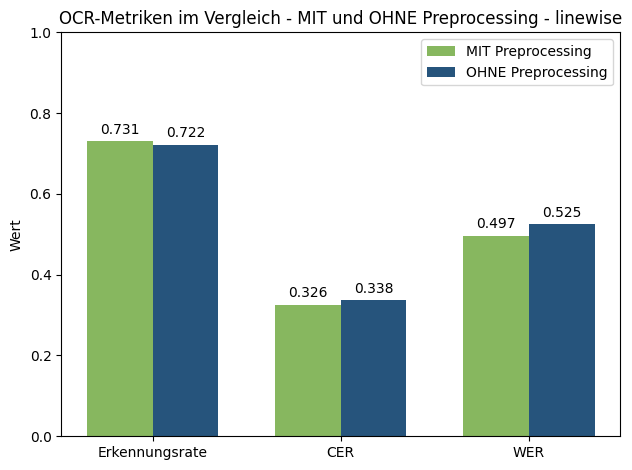

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Daten
metrics = ['Erkennungsrate', 'CER', 'WER']
values_preproc = [0.731, 0.326, 0.497]  
values = [0.722, 0.338, 0.525]  

x = np.arange(len(metrics))
width = 0.35

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, values_preproc, width, label='MIT Preprocessing', color='#87b75f')
bars2 = ax.bar(x + width/2, values, width, label='OHNE Preprocessing', color='#26547c')


# Beschriftung
ax.set_ylabel('Wert')
ax.set_title('OCR-Metriken im Vergleich - MIT und OHNE Preprocessing - linewise')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Werte anzeigen
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

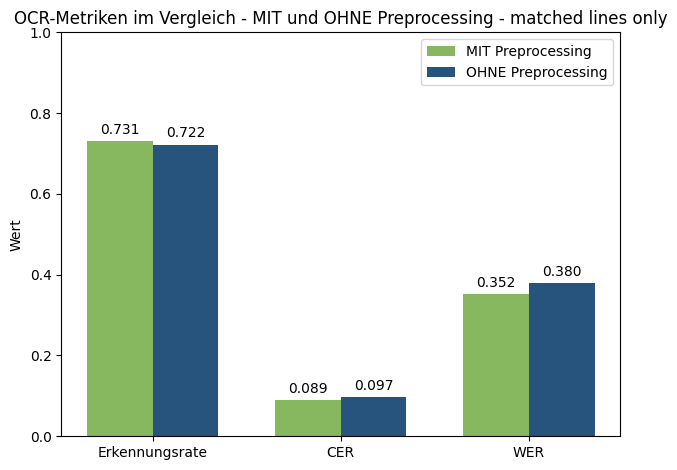

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Daten
metrics = ['Erkennungsrate', 'CER', 'WER']
values_preproc = [0.731, 0.089, 0.352]  
values = [0.722, 0.097, 0.380]  

x = np.arange(len(metrics))
width = 0.35

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, values_preproc, width, label='MIT Preprocessing', color='#87b75f')
bars2 = ax.bar(x + width/2, values, width, label='OHNE Preprocessing', color='#26547c')


# Beschriftung
ax.set_ylabel('Wert')
ax.set_title('OCR-Metriken im Vergleich - MIT und OHNE Preprocessing - matched lines only')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Werte anzeigen
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

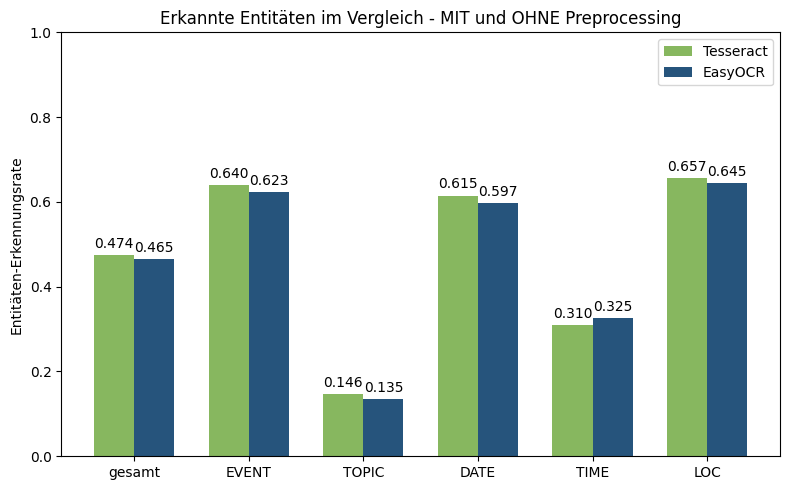

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Daten
metrics = ['gesamt', 'EVENT', 'TOPIC', 'DATE', 'TIME','LOC' ]
mit = [0.474, 0.640, 0.146, 0.615, 0.310, 0.657 ]  
ohne = [0.465, 0.623, 0.135, 0.597, 0.325, 0.645 ]  


x = np.arange(len(metrics))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, mit, width, label='Tesseract', color='#87b75f')
bars2 = ax.bar(x + width/2, ohne, width, label='EasyOCR', color='#26547c')


# Beschriftung
ax.set_ylabel('Entitäten-Erkennungsrate')
ax.set_title('Erkannte Entitäten im Vergleich - MIT und OHNE Preprocessing')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Werte anzeigen
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()